In [2]:
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
#constants of nature

mu0 = 4 * np.pi * 1e-7
e0 = 8.85e-12
c = np.sqrt(1 / (mu0 * e0))
print("the speed of light is:", c)

dt = 0.0005

the speed of light is: 299863380.46612763


In [4]:
t0 = 0
t1 = 30
timesteps = np.arange(t0, t1, dt)

In [5]:
E0 = 0.05
omega = np.sqrt(2)
external_force_arr = E0 * np.sin(omega * timesteps)
    

In [6]:
class Particle:
    
    def __init__(self, mass=1, charge=1, pos=np.array([0.0,0.0,0.0]), vel=np.array([0.0,0.0,0.0]), acc=np.array([0.0,0.0,0.0])):
        self.mass = mass
        self.charge = charge
        self.pos = pos
        self.vel = vel
        self.acc = acc

class Dipole:
    
    def __init__(self, timesteps, distance=1, charge=1):
        self.distance = distance
        self.charge = charge
        self.mass = 1
        self.particle1 = Particle(mass=self.mass, charge=self.charge, pos=np.array([-distance/3, 0,0]))
        self.particle2 = Particle(mass=self.mass, charge=self.charge, pos=np.array([distance/2, 0,0]))
        self.dipole_moment = self.charge * np.array([self.distance, 0, 0])
        self.force = 0
        self.timesteps = timesteps
        self.pos1 = np.zeros(self.timesteps.shape)
        self.pos2 = np.zeros(self.timesteps.shape)
        self.k = 1
        print(self.pos1.shape)
        
    def update(self, external_force):
        r = self.particle2.pos - self.particle1.pos
        
        spring_force = self.k * (np.linalg.norm(r) - self.distance) * (r / np.linalg.norm(r))
        force = spring_force + external_force * self.charge
        
        self.particle1.acc = force / self.particle1.mass
        self.particle2.acc = -force / self.particle2.mass
        self.particle1.vel = self.particle1.vel + self.particle1.acc * dt
        self.particle2.vel = self.particle2.vel + self.particle2.acc * dt
        
        self.particle1.pos += self.particle1.vel * dt
        self.particle2.pos += self.particle2.vel * dt
        
#         print(self.particle1.vel + self.particle1.acc * dt)

#         print(self.particle1.pos)
#         print(self.particle2.pos)
        
    def calc_trajectory(self):
        
        for i, time in enumerate(self.timesteps):
            self.pos1[i] = self.particle1.pos[0]
            self.pos2[i] = self.particle2.pos[0]
            
#             print(i)
#             print(time)
            
            external_force = np.array([external_force_arr[i], 0, 0])
            
            self.update(external_force)
            
        return self.pos1, self.pos2
        

(60000,)


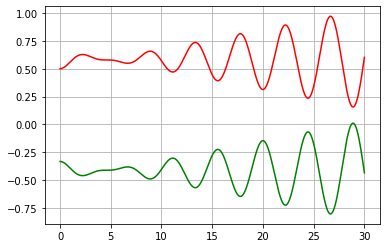

In [7]:
dipole = Dipole(timesteps)

pos1, pos2 = dipole.calc_trajectory()
# print(timesteps.shape)
# print(pos1)

plt.plot(timesteps, pos1, 'g')
plt.plot(timesteps, pos2, 'r')
plt.grid()


In [8]:
x = np.array([5,0,0])
r = np.linalg.norm(x)
print(x / r)

[1. 0. 0.]
